In [ ]:
# This is a classic example of a hierarchical "random effects" Bayesian model 
# The probabilistic specification and the code below can be found here:
# https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html
# https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#diagnosing-with-divergences

import logging
_log = logging.getLogger("pymc")
_log.setLevel(logging.INFO) # Option 0
#_log.setLevel(logging.WARNING) # Option 1
#_log.setLevel(logging.ERROR) # Option 2

# Suppose there are 8 groups with average measurements y and standard error sigma
# where the standard errors have to do with sample size and intergroup variaion
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
# Suppose we are interested in learning the overall average across all 8 groups
# accounting for the uncertainty in each of the measurements of the groups
# using the following probabilisitic programming specification
with pm.Model() as Centered_eight:
    # we assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5) 
    # and we assume the following probabilistic hierarchy
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    # Note that if tau was small, then the density evalution above 
    # could change rapidly for changes in theta
    # This means that the energy has high curvature 
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

# This model can be sampled using HMC
# The auxiliary variables are added to the specification "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True}) 

INFO:pymc:Auto-assigning NUTS sampler...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [mu, tau, theta]


INFO:pymc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 43 seconds.
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
# previous versions of pymc, i.e., pymc3 gave the following errors

#ERROR:pymc3:There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
#WARNING:pymc3:The acceptance probability does not match the target. It is 0.7073435948155605, but should be close to 0.8. Try to increase the number of tuning steps.
#ERROR:pymc3:There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
#WARNING:pymc3:The acceptance probability does not match the target. It is 0.6771097025238918, but should be close to 0.8. Try to increase the number of tuning steps.
#ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.

# but the most recent versions of pymc no longer track this, so
# `_log.setLevel(logging.WARNING)` and `_log.setLevel(logging.ERROR)`
# have no effect now

In [ ]:
# As is seen above, there are many divergences; and, the acceptance rate is quite low
# This is because the specification above induces high curature in the energy 
# as described above; but, here's a specification that alleviates this problem.

with pm.Model() as NonCentered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations below
    # so the energy still has high curvature with respect to tau; but, 
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, 
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True}) 
# The suggestion to "Increase `target_accept`" below means use smaller
# \delta time steps when evolving the Hamiltonian dynamics:
# this would result in fewer divergences and higher acceptances rates

INFO:pymc:Auto-assigning NUTS sampler...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [mu, tau, theta_t]


INFO:pymc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds.
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
# These warnings are no longer tracked
# ERROR:pymc3:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
# ERROR:pymc3:There were 40 divergences after tuning. Increase `target_accept` or reparameterize.

In [ ]:
# Current support for examining sampling diagnostics is given here
# https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/sampler-stats.html
# Demonstrations of posterior analysis is demonstrated here 
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#posterior-analysis
# and will be explored during your final homework assignment

Centered Parameterization:
- divergences require decreased step size and hence increasing HMC chain dependency
- and hence decreased effective sample size
Uncentered Parameterization:
- less divergences alows longer contour trajectories step size and hence increasing HMC chain dependency
- and hence decreased effective sample size


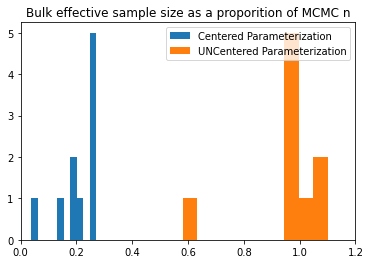

In [ ]:
print('Centered Parameterization:')
print('- divergences require decreased step size and hence increasing HMC chain dependency')
print('- and hence decreased effective sample size')
with Centered_eight: 
  plt.hist(pm.summary(fit_C)['ess_bulk']/10000,
           label = "Centered Parameterization")
print('Uncentered Parameterization:')
print('- less divergences alows longer contour trajectories step size and hence increasing HMC chain dependency')
print('- and hence decreased effective sample size')
with NonCentered_eight: 
  plt.hist(pm.summary(fit_NC)['ess_bulk'][9:]/10000,
           label = "UNCentered Parameterization")
plt.legend(); plt.title("Bulk effective sample size as a proporition of MCMC n"); plt.xlim((0,1.2));

In [ ]:
# Above are histograms of the effective sample size 
# as a fraction of of the number of HMC samples
# for each of the parameters in the model
with Centered_eight: 
  print(pm.summary(fit_C)['ess_bulk'])

mu          1534.0
theta[0]    1858.0
theta[1]    2541.0
theta[2]    2645.0
theta[3]    2686.0
theta[4]    2197.0
theta[5]    2558.0
theta[6]    1944.0
theta[7]    2705.0
tau          381.0
Name: ess_bulk, dtype: float64


In [ ]:
# the noncentered parameterization keeps track of theta_t on the N(0,1) scale
# but the deterministically transformed theta is really the parameter that matters
with NonCentered_eight: 
  print(pm.summary(fit_NC)['ess_bulk'])

mu             9312.0
theta_t[0]    10129.0
theta_t[1]     9280.0
theta_t[2]    11847.0
theta_t[3]     9086.0
theta_t[4]     7475.0
theta_t[5]     8972.0
theta_t[6]     7980.0
theta_t[7]     8229.0
tau            5819.0
theta[0]       9928.0
theta[1]      11003.0
theta[2]       9448.0
theta[3]      10218.0
theta[4]       9752.0
theta[5]      10726.0
theta[6]       9559.0
theta[7]       9480.0
Name: ess_bulk, dtype: float64


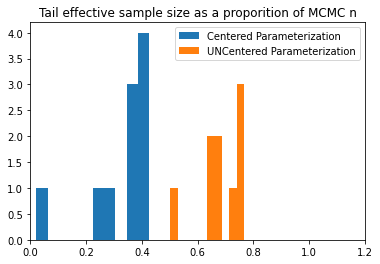

In [ ]:
# Here is another interesting diagnostic which shows the effective sample size
# when restricted to samples in the tails of the HMC samples.
# It suggests how efficiently the HMC samples traverse the extremes of the distribution
with Centered_eight: 
  plt.hist(pm.summary(fit_C)['ess_tail']/10000,
           label = "Centered Parameterization")
with NonCentered_eight: 
  plt.hist(pm.summary(fit_NC)['ess_tail'][9:]/10000,
           label = "UNCentered Parameterization")
plt.legend(); plt.title("Tail effective sample size as a proporition of MCMC n"); plt.xlim((0,1.2));